In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sklearn as skl
import tensorflow as tf
import yfinance as yf
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from pathlib import Path
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import json
import os
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
import seaborn as sb
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [23]:
Soybeans=yf.Ticker("ZS=F")
Corn=yf.Ticker("ZC=F")
Wheat=yf.Ticker("ZW=F")
Cotton=yf.Ticker("CT=F")
Crude=yf.Ticker("CL=F")
USDBRL=yf.Ticker("BRL=X")
EURUSD=yf.Ticker("EURUSD=X")
IR=yf.Ticker("^TNX")
Sugar=yf.Ticker("SB=F")
SoyOil=yf.Ticker("ZL=F")

Hold_Signal=-.05
window = 90  # trading days in rolling window
dpy = 252  # trading days per year
ann_factor = dpy / window

In [176]:
Sugar_H=Sugar.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Sugar_H["Range"]=Sugar_H["High"]-Sugar_H["Low"]
Sugar_H=Sugar_H.drop(["High","Low"], axis=1)

Sugar_H['log_rtn'] = np.log(Sugar_H['Close']).diff()
Sugar_H['real_var'] = np.square(Sugar_H['log_rtn']).rolling(window).sum() * ann_factor
Sugar_H['Vol'] = np.sqrt(Sugar_H['real_var'])

Sugar_P=Sugar_H[:len(Sugar_H)-window]
Sugar_P=Sugar_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Sugar_H=Sugar_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Sugar_P=Sugar_P.drop("Date",axis=1)

Sugar_H["Price_Change"]=(Sugar_H["Close"]-Sugar_P["Close"])/Sugar_P["Close"]
Sugar_H["Buy/Hold"]=np.where(Sugar_H["Price_Change"]< Hold_Signal, "Hold","Buy")

Sugar_P

,Close,Range,Vol
0,14.88,0.470000,0.291116
1,14.91,0.730000,0.291255
2,14.48,0.450000,0.290771
3,14.65,0.390000,0.290702
4,14.72,0.570000,0.291503
...,...,...,...
5065,9.20,0.160001,0.614862
5066,9.22,0.230000,0.614932
5067,9.17,0.320000,0.614873
5068,8.83,0.230000,0.612354


In [177]:
SoyOil_H=SoyOil.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
SoyOil_H["Range"]=SoyOil_H["High"]-SoyOil_H["Low"]
SoyOil_H=SoyOil_H.drop(["High","Low"], axis=1)

SoyOil_H['log_rtn'] = np.log(SoyOil_H['Close']).diff()


SoyOil_H['real_var'] = np.square(SoyOil_H['log_rtn']).rolling(window).sum() * ann_factor
SoyOil_H['Vol'] = np.sqrt(SoyOil_H['real_var'])


SoyOil_P=SoyOil_H[:len(SoyOil_H)-window]
SoyOil_P=SoyOil_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
SoyOil_H=SoyOil_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
SoyOil_P=SoyOil_P.drop("Date",axis=1)

SoyOil_H["Price_Change"]=(SoyOil_H["Close"]-SoyOil_P["Close"])/SoyOil_P["Close"]
SoyOil_H["Buy/Hold"]=np.where(SoyOil_H["Price_Change"]< Hold_Signal, "Hold","Buy")

SoyOil_P

,Close,Range,Vol
0,35.480000,0.990002,0.234764
1,35.340000,0.700001,0.235143
2,35.470001,1.360001,0.235462
3,34.389999,1.139999,0.230726
4,33.779999,0.790001,0.230207
...,...,...,...
4968,15.540000,0.340000,0.208599
4969,15.580000,0.230000,0.209357
4970,15.520000,0.150000,0.212498
4971,15.560000,0.179999,0.229789


In [178]:
Soybeans_H=Soybeans.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Soybeans_H["Range"]=Soybeans_H["High"]-Soybeans_H["Low"]
Soybeans_H=Soybeans_H.drop(["High","Low"], axis=1)

Soybeans_H['log_rtn'] = np.log(Soybeans_H['Close']).diff()

# Var Swap (returns are not demeaned)
Soybeans_H['real_var'] = np.square(Soybeans_H['log_rtn']).rolling(window).sum() * ann_factor
Soybeans_H['Vol'] = np.sqrt(Soybeans_H['real_var'])


Soybeans_P=Soybeans_H[:len(Soybeans_H)-window]
Soybeans_P=Soybeans_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Soybeans_H=Soybeans_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Soybeans_P=Soybeans_P.drop("Date",axis=1)

Soybeans_H["Price_Change"]=(Soybeans_H["Close"]-Soybeans_P["Close"])/Soybeans_P["Close"]
Soybeans_H["Buy/Hold"]=np.where(Soybeans_H["Price_Change"]< Hold_Signal, "Hold","Buy")
#Soybeans_H["Past_Price"]=Soybeans_P["Close"]
#Soybeans_H=Soybeans_H.set_index('Date')
#Soybeans_P=Soybeans_P.set_index('Date')
#Soybeans_H["Buy/Hold"].hist(figsize = (12,10))
#plt.show()
Soybeans_P

,Close,Range,Vol
0,1105.00,16.50,0.174978
1,1098.50,11.75,0.174715
2,1101.75,31.75,0.175558
3,1079.00,25.25,0.175365
4,1059.00,17.50,0.172572
...,...,...,...
4944,459.75,1.25,0.169929
4945,461.25,1.50,0.170212
4946,459.75,2.25,0.170160
4947,467.00,2.00,0.168136


In [179]:
Corn_H=Corn.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Corn_H["Range"]=Corn_H["High"]-Corn_H["Low"]
Corn_H=Corn_H.drop(["High","Low"], axis=1)


Corn_H['log_rtn'] = np.log(Corn_H['Close']).diff()

# Var Swap (returns are not demeaned)
Corn_H['real_var'] = np.square(Corn_H['log_rtn']).rolling(window).sum() * ann_factor
Corn_H['Vol'] = np.sqrt(Corn_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

Corn_P=Corn_H[:len(Corn_H)-90]
Corn_P=Corn_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Corn_H=Corn_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Corn_P=Corn_P.drop("Date",axis=1)

Corn_H["Price_Change"]=(Corn_H["Close"]-Corn_P["Close"])/Corn_P["Close"]
Corn_H["Buy/Hold"]=np.where(Corn_H["Price_Change"]< Hold_Signal, "Hold","Buy")
#Corn_H["Past_Price"]=Corn_P["Close"]
#Corn_H=Corn_H.set_index('Date')
#Corn_P=Corn_P.set_index('Date')
#Corn_H["Buy/Hold"].hist(figsize = (12,10))
#plt.show()
Corn_P

,Close,Range,Vol
0,407.50,8.25,0.215773
1,406.75,6.25,0.217542
2,409.25,13.25,0.222435
3,405.25,9.50,0.230242
4,401.00,8.00,0.234556
...,...,...,...
4952,220.00,1.00,0.183245
4953,218.00,0.00,0.183278
4954,215.50,0.00,0.185854
4955,210.00,0.00,0.181116


In [180]:
Wheat_H=Wheat.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Wheat_H["Range"]=Wheat_H["High"]-Wheat_H["Low"]
Wheat_H=Wheat_H.drop(["High","Low"], axis=1)


Wheat_H['log_rtn'] = np.log(Wheat_H['Close']).diff()

# Var Swap (returns are not demeaned)
Wheat_H['real_var'] = np.square(Wheat_H['log_rtn']).rolling(window).sum() * ann_factor
Wheat_H['Vol'] = np.sqrt(Wheat_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

Wheat_P=Wheat_H[:len(Wheat_H)-90]
Wheat_P=Wheat_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Wheat_H=Wheat_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Wheat_P=Wheat_P.drop("Date",axis=1)

Wheat_H["Price_Change"]=(Wheat_H["Close"]-Wheat_P["Close"])/Wheat_P["Close"]
Wheat_H["Buy/Hold"]=np.where(Wheat_H["Price_Change"]< Hold_Signal, "Hold","Buy")
#Wheat_H["Past_Price"]=Wheat_P["Close"]
#Wheat_H=Wheat_H.set_index('Date')
#Wheat_P=Wheat_P.set_index('Date')

Wheat_P

,Close,Range,Vol
0,597.50,12.00,0.274386
1,602.00,14.00,0.275695
2,609.25,20.25,0.276556
3,606.00,12.75,0.276842
4,608.00,12.50,0.279679
...,...,...,...
4940,252.50,2.00,0.245302
4941,256.25,1.75,0.244064
4942,256.50,1.75,0.244438
4943,261.00,1.00,0.244068


In [181]:
Cotton_H=Cotton.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Cotton_H["Range"]=Cotton_H["High"]-Cotton_H["Low"]
Cotton_H=Cotton_H.drop(["High","Low"], axis=1)


Cotton_H['log_rtn'] = np.log(Cotton_H['Close']).diff()

# Var Swap (returns are not demeaned)
Cotton_H['real_var'] = np.square(Cotton_H['log_rtn']).rolling(window).sum() * ann_factor
Cotton_H['Vol'] = np.sqrt(Cotton_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

Cotton_P=Cotton_H[:len(Cotton_H)-90]
Cotton_P=Cotton_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Cotton_H=Cotton_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Cotton_P=Cotton_P.drop("Date",axis=1)


Cotton_H["Price_Change"]=(Cotton_H["Close"]-Cotton_P["Close"])/Cotton_P["Close"]
Cotton_H["Buy/Hold"]=np.where(Cotton_H["Price_Change"]< Hold_Signal, "Hold","Buy")
#Cotton_H["Past_Price"]=Cotton_P["Close"]
#Cotton_H=Cotton_H.set_index('Date')
#Cotton_P=Cotton_P.set_index('Date')
Cotton_P

,Close,Range,Vol
0,70.000000,1.820000,0.194771
1,68.620003,1.719994,0.192308
2,70.070000,1.080002,0.194001
3,70.230003,1.090004,0.197601
4,70.239998,1.599998,0.199291
...,...,...,...
5104,62.070000,1.299999,0.257533
5105,62.619999,0.550003,0.263868
5106,62.750000,1.489998,0.264379
5107,62.230000,1.000000,0.265405


In [182]:
Crude_H=Crude.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
Crude_H["Range"]=Crude_H["High"]-Crude_H["Low"]
Crude_H=Crude_H.drop(["High","Low"], axis=1)


Crude_H['log_rtn'] = np.log(Crude_H['Close']).diff()

# Var Swap (returns are not demeaned)
Crude_H['real_var'] = np.square(Crude_H['log_rtn']).rolling(window).sum() * ann_factor
Crude_H['Vol'] = np.sqrt(Crude_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

Crude_P=Crude_H[:len(Crude_H)-90]
Crude_P=Crude_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Crude_H=Crude_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
Crude_P=Crude_P.drop("Date",axis=1)
Crude_P

,Close,Range,Vol
0,40.290001,4.170002,0.398191
1,37.139999,1.549999,0.375754
2,38.790001,1.079998,0.369381
3,39.150002,1.990002,0.369507
4,37.660000,1.750000,0.367426
...,...,...,...
4860,27.719999,0.850000,0.480530
4861,27.350000,1.250000,0.480065
4862,28.000000,1.000000,0.480317
4863,28.200001,0.930000,0.480676


In [183]:
USDBRL_H=USDBRL.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)

USDBRL_H["Range"]=USDBRL_H["High"]-USDBRL_H["Low"]
USDBRL_H=USDBRL_H.drop(["High","Low"], axis=1)


USDBRL_H['log_rtn'] = np.log(USDBRL_H['Close']).diff()

# Var Swap (returns are not demeaned)
USDBRL_H['real_var'] = np.square(USDBRL_H['log_rtn']).rolling(window).sum() * ann_factor
USDBRL_H['Vol'] = np.sqrt(USDBRL_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

USDBRL_P=USDBRL_H[:len(USDBRL_H)-90]
USDBRL_P=USDBRL_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
USDBRL_H=USDBRL_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()#[:len(Soybeans_H)]
USDBRL_P=USDBRL_P.drop("Date",axis=1)
USDBRL_P

,Close,Range,Vol
0,5.3272,0.063013,0.190490
1,5.4149,0.081942,0.188829
2,5.4570,0.091900,0.189816
3,5.4567,0.071429,0.189846
4,5.3900,0.077600,0.188734
...,...,...,...
3866,2.8840,0.000000,0.079259
3867,2.8840,0.014000,0.079424
3868,2.8700,0.016000,0.079301
3869,2.8740,0.005000,0.079267


In [184]:
EURUSD_H=EURUSD.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
EURUSD_H["Range"]=EURUSD_H["High"]-EURUSD_H["Low"]
EURUSD_H=EURUSD_H.drop(["High","Low"], axis=1)


EURUSD_H['log_rtn'] = np.log(EURUSD_H['Close']).diff()

# Var Swap (returns are not demeaned)
EURUSD_H['real_var'] = np.square(EURUSD_H['log_rtn']).rolling(window).sum() * ann_factor
EURUSD_H['Vol'] = np.sqrt(EURUSD_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

EURUSD_P=EURUSD_H[:len(EURUSD_H)-90]
EURUSD_P=EURUSD_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
EURUSD_H=EURUSD_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()#[:len(Soybeans_H)]
EURUSD_P=EURUSD_P.drop("Date",axis=1)

EURUSD_P

,Close,Range,Vol
0,1.186366,0.003985,0.066598
1,1.185944,0.004719,0.067282
2,1.184525,0.005399,0.067456
3,1.180339,0.003421,0.067275
4,1.178030,0.006341,0.067620
...,...,...,...
4284,1.208605,0.004604,0.123308
4285,1.207700,0.015008,0.124165
4286,1.216604,0.013900,0.123692
4287,1.213106,0.015698,0.123687


In [185]:
IR_H=IR.history(period="Max").drop(["Dividends", "Stock Splits","Open","Volume"], axis=1)
IR_H["Range"]=IR_H["High"]-IR_H["Low"]
IR_H=IR_H.drop(["High","Low"], axis=1)


IR_H['log_rtn'] = np.log(IR_H['Close']).diff()

# Var Swap (returns are not demeaned)
IR_H['real_var'] = np.square(IR_H['log_rtn']).rolling(window).sum() * ann_factor
IR_H['Vol'] = np.sqrt(IR_H['real_var'])

# Classical (returns are demeaned, dof=1)
#df['real_var'] = df['log_rtn'].rolling(window).var() * ann_factor
#df['real_vol'] = np.sqrt(df['real_var'])

IR_P=IR_H[:len(IR_H)-90]
IR_P=IR_P.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()
IR_H=IR_H.sort_values(by="Date", ascending=False).dropna().drop(["log_rtn","real_var"],axis=1).reset_index()#[:len(Soybeans_H)]
IR_P=IR_P.drop("Date",axis=1)
IR_P

,Close,Range,Vol
0,0.958,0.072,0.743309
1,0.820,0.055,0.696996
2,0.776,0.042,0.694675
3,0.768,0.045,0.695860
4,0.882,0.025,0.656190
...,...,...,...
14597,3.870,0.000,0.082033
14598,3.860,0.000,0.082024
14599,3.870,0.000,0.082863
14600,3.850,0.000,0.084082


In [186]:
Data=[Corn_H, Wheat_H, Cotton_H, Crude_H, USDBRL_H, EURUSD_H, IR_H,Soybeans_H,Sugar_H, SoyOil_H,Corn_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P,Soybeans_P,Sugar_P, SoyOil_P]
for df in Data:
    df.drop(columns = ['Range',"Vol"], inplace= True)

In [187]:
Corn_H

,Date,Close,Price_Change,Buy/Hold
0,2021-03-24,552.50,0.355828,Buy
1,2021-03-23,551.25,0.355255,Buy
2,2021-03-22,549.00,0.341478,Buy
3,2021-03-19,557.75,0.376311,Buy
4,2021-03-18,546.50,0.362843,Buy
...,...,...,...,...
5042,2000-12-26,220.00,NaN,Buy
5043,2000-12-21,218.00,NaN,Buy
5044,2000-12-18,215.50,NaN,Buy
5045,2000-12-04,210.00,NaN,Buy


In [188]:
#Data_H=["Corn_H", "Wheat_H", "Cotton_H", "Crude_H", "USDBRL_H", "EURUSD_H", "IR_H","Soybeans_H","Sugar_H", "SoyOil_H"]
#Data_P=[Corn_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P,Soybeans_P,Sugar_P, SoyOil_P]




#for df in Data_H:
    #eval(df).rename(columns={"Close":df}, inplace=True)[:len(USDBRL_H)]

In [189]:
Sugar_H=Sugar_H.rename(columns={"Close": "Sugar Close"})[:len(USDBRL_H)]
SoyOil_H=SoyOil_H.rename(columns={"Close": "SoyOil Close"})[:len(USDBRL_H)]
Sugar_P=Sugar_P.rename(columns={"Close": "Sugar P_Close"})[:len(USDBRL_P)]
SoyOil_P=SoyOil_P.rename(columns={ "Close": "SoyOil P_Close"})[:len(USDBRL_P)]

In [190]:
Soybeans_H=Soybeans_H.rename(columns={"Close": "Soybeans Close"})[:len(USDBRL_H)]
Corn_H=Corn_H.rename(columns={"Range": "Corn Range", "Close": "Corn Close"})[:len(USDBRL_H)]

Wheat_H=Wheat_H.rename(columns={"Close": "Wheat Close"})[:len(USDBRL_H)]
Cotton_H=Cotton_H.rename(columns={"Close": "Cotton Close"})[:len(USDBRL_H)]
Crude_H=Crude_H.rename(columns={"Close": "Crude Close"})[:len(USDBRL_H)]
USDBRL_H=USDBRL_H.rename(columns={ "Close": "USDBRL Close"})[:len(USDBRL_H)]
EURUSD_H=EURUSD_H.rename(columns={ "Close": "EURUSD Close"})[:len(USDBRL_H)]
IR_H=IR_H.rename(columns={ "Close": "IR Close"})[:len(USDBRL_H)]

In [191]:
Soybeans_P=Soybeans_P.rename(columns={"Close": "Soybeans P_Close"})[:len(USDBRL_P)]
Corn_P=Corn_P.rename(columns={ "Close": "Corn P_Close"})[:len(USDBRL_P)]

Wheat_P=Wheat_P.rename(columns={"Close": "Wheat P_Close"})[:len(USDBRL_P)]
Cotton_P=Cotton_P.rename(columns={"Close": "Cotton P_Close"})[:len(USDBRL_P)]
Crude_P=Crude_P.rename(columns={"Close": "Crude P_Close"})[:len(USDBRL_P)]
USDBRL_P=USDBRL_P.rename(columns={ "Close": "USDBRL P_Close"})[:len(USDBRL_P)]
EURUSD_P=EURUSD_P.rename(columns={ "Close": "EURUSD P_Close"})[:len(USDBRL_P)]
IR_P=IR_P.rename(columns={ "Close": "IR P_Close"})[:len(USDBRL_P)]

In [192]:
Prices_S = [Corn_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P, SoyOil_P, Sugar_P]
Prices_C= [Soybeans_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P, SoyOil_P, Sugar_P]
Prices_W= [Soybeans_P, Corn_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P,SoyOil_P, Sugar_P]
Prices_Ctn= [Soybeans_P, Wheat_P, Corn_P, Crude_P, USDBRL_P, EURUSD_P, IR_P, SoyOil_P, Sugar_P]
Prices_Sb=[Corn_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P,Soybeans_P,SoyOil_P]
Prices_SO=[Corn_P, Wheat_P, Cotton_P, Crude_P, USDBRL_P, EURUSD_P, IR_P,Soybeans_P,Sugar_P]

In [193]:
for price in Prices_S:
    Soybeans_H=Soybeans_H.merge(price, how="outer", left_index=True, right_index=True)
    
Soybeans_H=Soybeans_H.drop("Date", axis=1)
Soybeans_H


,Soybeans Close,Price_Change,Buy/Hold,Corn P_Close,Wheat P_Close,Cotton P_Close,Crude P_Close,USDBRL P_Close,EURUSD P_Close,IR P_Close,SoyOil P_Close,Sugar P_Close
0,1431.50,0.295475,Buy,407.50,597.50,70.000000,40.290001,5.3272,1.186366,0.958,35.480000,14.88
1,1423.25,0.295630,Buy,406.75,602.00,68.620003,37.139999,5.4149,1.185944,0.820,35.340000,14.91
2,1417.50,0.286590,Buy,409.25,609.25,70.070000,38.790001,5.4570,1.184525,0.776,35.470001,14.48
3,1416.25,0.312558,Buy,405.25,606.00,70.230003,39.150002,5.4567,1.180339,0.768,34.389999,14.65
4,1392.25,0.314684,Buy,401.00,608.00,70.239998,37.660000,5.3900,1.178030,0.882,33.779999,14.72
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,629.25,0.123661,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,633.25,0.147712,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3958,620.75,0.145824,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3959,623.50,0.167603,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
for price in Prices_C:
    Corn_H=Corn_H.merge(price, how="outer", left_index=True, right_index=True)
    
Corn_H=Corn_H.drop("Date", axis=1)


In [195]:
for price in Prices_W:
    Wheat_H=Wheat_H.merge(price, how="outer", left_index=True, right_index=True)
    
Wheat_H=Wheat_H.drop("Date", axis=1)
Wheat_H

,Wheat Close,Price_Change,Buy/Hold,Soybeans P_Close,Corn P_Close,Cotton P_Close,Crude P_Close,USDBRL P_Close,EURUSD P_Close,IR P_Close,SoyOil P_Close,Sugar P_Close
0,624.75,0.045607,Buy,1105.00,407.50,70.000000,40.290001,5.3272,1.186366,0.958,35.480000,14.88
1,634.75,0.054402,Buy,1098.50,406.75,68.620003,37.139999,5.4149,1.185944,0.820,35.340000,14.91
2,627.25,0.029545,Buy,1101.75,409.25,70.070000,38.790001,5.4570,1.184525,0.776,35.470001,14.48
3,627.00,0.034653,Buy,1079.00,405.25,70.230003,39.150002,5.4567,1.180339,0.768,34.389999,14.65
4,630.50,0.037007,Buy,1059.00,401.00,70.239998,37.660000,5.3900,1.178030,0.882,33.779999,14.72
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,309.50,0.005686,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,315.00,0.016949,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3958,310.00,0.005677,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3959,306.25,0.021685,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
for price in Prices_Ctn:
    Cotton_H=Cotton_H.merge(price, how="outer", left_index=True, right_index=True)

Cotton_H=Cotton_H.drop("Date", axis=1)    
Cotton_H

,Cotton Close,Price_Change,Buy/Hold,Soybeans P_Close,Wheat P_Close,Corn P_Close,Crude P_Close,USDBRL P_Close,EURUSD P_Close,IR P_Close,SoyOil P_Close,Sugar P_Close
0,82.419998,0.177429,Buy,1105.00,597.50,407.50,40.290001,5.3272,1.186366,0.958,35.480000,14.88
1,83.529999,0.217284,Buy,1098.50,602.00,406.75,37.139999,5.4149,1.185944,0.820,35.340000,14.91
2,84.620003,0.207650,Buy,1101.75,609.25,409.25,38.790001,5.4570,1.184525,0.776,35.470001,14.48
3,84.680000,0.205752,Buy,1079.00,606.00,405.25,39.150002,5.4567,1.180339,0.768,34.389999,14.65
4,85.449997,0.216543,Buy,1059.00,608.00,401.00,37.660000,5.3900,1.178030,0.882,33.779999,14.72
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,53.750000,0.208137,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,55.080002,0.248413,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3958,56.799999,0.268707,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3959,55.930000,0.270848,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
for price in Prices_Sb:
    Sugar_H=Sugar_H.merge(price, how="outer", left_index=True, right_index=True)

Sugar_H=Sugar_H.drop("Date", axis=1)    
Sugar_H

,Sugar Close,Price_Change,Buy/Hold,Corn P_Close,Wheat P_Close,Cotton P_Close,Crude P_Close,USDBRL P_Close,EURUSD P_Close,IR P_Close,Soybeans P_Close,SoyOil P_Close
0,15.57,0.046371,Buy,407.50,597.50,70.000000,40.290001,5.3272,1.186366,0.958,1105.00,35.480000
1,15.43,0.034876,Buy,406.75,602.00,68.620003,37.139999,5.4149,1.185944,0.820,1098.50,35.340000
2,15.53,0.072514,Buy,409.25,609.25,70.070000,38.790001,5.4570,1.184525,0.776,1101.75,35.470001
3,15.76,0.075768,Buy,405.25,606.00,70.230003,39.150002,5.4567,1.180339,0.768,1079.00,34.389999
4,15.89,0.079484,Buy,401.00,608.00,70.239998,37.660000,5.3900,1.178030,0.882,1059.00,33.779999
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,8.35,-0.075304,Hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,8.26,-0.099237,Hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3958,8.49,-0.060841,Hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3959,8.39,-0.073951,Hold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
for price in Prices_SO:
    SoyOil_H=SoyOil_H.merge(price, how="outer", left_index=True, right_index=True)
    
SoyOil_H=SoyOil_H.drop("Date", axis=1)
SoyOil_H

,SoyOil Close,Price_Change,Buy/Hold,Corn P_Close,Wheat P_Close,Cotton P_Close,Crude P_Close,USDBRL P_Close,EURUSD P_Close,IR P_Close,Soybeans P_Close,Sugar P_Close
0,57.410000,0.618095,Buy,407.50,597.50,70.000000,40.290001,5.3272,1.186366,0.958,1105.00,14.88
1,57.020000,0.613469,Buy,406.75,602.00,68.620003,37.139999,5.4149,1.185944,0.820,1098.50,14.91
2,56.369999,0.589230,Buy,409.25,609.25,70.070000,38.790001,5.4570,1.184525,0.776,1101.75,14.48
3,53.869999,0.566444,Buy,405.25,606.00,70.230003,39.150002,5.4567,1.180339,0.768,1079.00,14.65
4,53.520000,0.584370,Buy,401.00,608.00,70.239998,37.660000,5.3900,1.178030,0.882,1059.00,14.72
...,...,...,...,...,...,...,...,...,...,...,...,...
3956,22.040001,0.095427,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,22.260000,0.098175,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3958,22.020000,0.096614,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3959,22.160000,0.111334,Buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


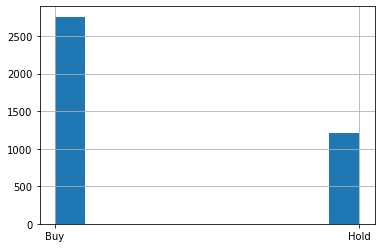

In [199]:
SoyOil_H["Buy/Hold"].hist()

In [200]:
Data=[Corn_H, Wheat_H, Cotton_H, Crude_H, USDBRL_H, EURUSD_H, IR_H,Soybeans_H,Sugar_H, SoyOil_H]
client = MongoClient("mongodb://localhost:27017/Group_Project")
db=client.Group_Project


In [201]:
records=json.loads(Soybeans_H.T.to_json()).values()
db.Soybeans.insert(records)

[ObjectId('605b86e50aa32c20e3a5b502'),
 ObjectId('605b86e50aa32c20e3a5b503'),
 ObjectId('605b86e50aa32c20e3a5b504'),
 ObjectId('605b86e50aa32c20e3a5b505'),
 ObjectId('605b86e50aa32c20e3a5b506'),
 ObjectId('605b86e50aa32c20e3a5b507'),
 ObjectId('605b86e50aa32c20e3a5b508'),
 ObjectId('605b86e50aa32c20e3a5b509'),
 ObjectId('605b86e50aa32c20e3a5b50a'),
 ObjectId('605b86e50aa32c20e3a5b50b'),
 ObjectId('605b86e50aa32c20e3a5b50c'),
 ObjectId('605b86e50aa32c20e3a5b50d'),
 ObjectId('605b86e50aa32c20e3a5b50e'),
 ObjectId('605b86e50aa32c20e3a5b50f'),
 ObjectId('605b86e50aa32c20e3a5b510'),
 ObjectId('605b86e50aa32c20e3a5b511'),
 ObjectId('605b86e50aa32c20e3a5b512'),
 ObjectId('605b86e50aa32c20e3a5b513'),
 ObjectId('605b86e50aa32c20e3a5b514'),
 ObjectId('605b86e50aa32c20e3a5b515'),
 ObjectId('605b86e50aa32c20e3a5b516'),
 ObjectId('605b86e50aa32c20e3a5b517'),
 ObjectId('605b86e50aa32c20e3a5b518'),
 ObjectId('605b86e50aa32c20e3a5b519'),
 ObjectId('605b86e50aa32c20e3a5b51a'),
 ObjectId('605b86e50aa32c

In [202]:
records=json.loads(Sugar_H.T.to_json()).values()
db.Sugar.insert(records)

[ObjectId('605b88590aa32c20e3a5c47b'),
 ObjectId('605b88590aa32c20e3a5c47c'),
 ObjectId('605b88590aa32c20e3a5c47d'),
 ObjectId('605b88590aa32c20e3a5c47e'),
 ObjectId('605b88590aa32c20e3a5c47f'),
 ObjectId('605b88590aa32c20e3a5c480'),
 ObjectId('605b88590aa32c20e3a5c481'),
 ObjectId('605b88590aa32c20e3a5c482'),
 ObjectId('605b88590aa32c20e3a5c483'),
 ObjectId('605b88590aa32c20e3a5c484'),
 ObjectId('605b88590aa32c20e3a5c485'),
 ObjectId('605b88590aa32c20e3a5c486'),
 ObjectId('605b88590aa32c20e3a5c487'),
 ObjectId('605b88590aa32c20e3a5c488'),
 ObjectId('605b88590aa32c20e3a5c489'),
 ObjectId('605b88590aa32c20e3a5c48a'),
 ObjectId('605b88590aa32c20e3a5c48b'),
 ObjectId('605b88590aa32c20e3a5c48c'),
 ObjectId('605b88590aa32c20e3a5c48d'),
 ObjectId('605b88590aa32c20e3a5c48e'),
 ObjectId('605b88590aa32c20e3a5c48f'),
 ObjectId('605b88590aa32c20e3a5c490'),
 ObjectId('605b88590aa32c20e3a5c491'),
 ObjectId('605b88590aa32c20e3a5c492'),
 ObjectId('605b88590aa32c20e3a5c493'),
 ObjectId('605b88590aa32c

In [172]:
records=json.loads(SoyOil_H.T.to_json()).values()
db.SoyOil.insert(records)

[ObjectId('605b74030aa32c20e3a5960f'),
 ObjectId('605b74030aa32c20e3a59610'),
 ObjectId('605b74030aa32c20e3a59611'),
 ObjectId('605b74030aa32c20e3a59612'),
 ObjectId('605b74030aa32c20e3a59613'),
 ObjectId('605b74030aa32c20e3a59614'),
 ObjectId('605b74030aa32c20e3a59615'),
 ObjectId('605b74030aa32c20e3a59616'),
 ObjectId('605b74030aa32c20e3a59617'),
 ObjectId('605b74030aa32c20e3a59618'),
 ObjectId('605b74030aa32c20e3a59619'),
 ObjectId('605b74030aa32c20e3a5961a'),
 ObjectId('605b74030aa32c20e3a5961b'),
 ObjectId('605b74030aa32c20e3a5961c'),
 ObjectId('605b74030aa32c20e3a5961d'),
 ObjectId('605b74030aa32c20e3a5961e'),
 ObjectId('605b74030aa32c20e3a5961f'),
 ObjectId('605b74030aa32c20e3a59620'),
 ObjectId('605b74030aa32c20e3a59621'),
 ObjectId('605b74030aa32c20e3a59622'),
 ObjectId('605b74030aa32c20e3a59623'),
 ObjectId('605b74030aa32c20e3a59624'),
 ObjectId('605b74030aa32c20e3a59625'),
 ObjectId('605b74030aa32c20e3a59626'),
 ObjectId('605b74030aa32c20e3a59627'),
 ObjectId('605b74030aa32c

In [204]:
records=json.loads(Corn_H.T.to_json()).values()
db.Corn.insert(records)

[ObjectId('605b8ab50aa32c20e3a5e36d'),
 ObjectId('605b8ab50aa32c20e3a5e36e'),
 ObjectId('605b8ab50aa32c20e3a5e36f'),
 ObjectId('605b8ab50aa32c20e3a5e370'),
 ObjectId('605b8ab50aa32c20e3a5e371'),
 ObjectId('605b8ab50aa32c20e3a5e372'),
 ObjectId('605b8ab50aa32c20e3a5e373'),
 ObjectId('605b8ab50aa32c20e3a5e374'),
 ObjectId('605b8ab50aa32c20e3a5e375'),
 ObjectId('605b8ab50aa32c20e3a5e376'),
 ObjectId('605b8ab50aa32c20e3a5e377'),
 ObjectId('605b8ab50aa32c20e3a5e378'),
 ObjectId('605b8ab50aa32c20e3a5e379'),
 ObjectId('605b8ab50aa32c20e3a5e37a'),
 ObjectId('605b8ab50aa32c20e3a5e37b'),
 ObjectId('605b8ab50aa32c20e3a5e37c'),
 ObjectId('605b8ab50aa32c20e3a5e37d'),
 ObjectId('605b8ab50aa32c20e3a5e37e'),
 ObjectId('605b8ab50aa32c20e3a5e37f'),
 ObjectId('605b8ab50aa32c20e3a5e380'),
 ObjectId('605b8ab50aa32c20e3a5e381'),
 ObjectId('605b8ab50aa32c20e3a5e382'),
 ObjectId('605b8ab50aa32c20e3a5e383'),
 ObjectId('605b8ab50aa32c20e3a5e384'),
 ObjectId('605b8ab50aa32c20e3a5e385'),
 ObjectId('605b8ab50aa32c

In [203]:
records=json.loads(Wheat_H.T.to_json()).values()
db.Wheat.insert(records)

[ObjectId('605b8a7e0aa32c20e3a5d3f4'),
 ObjectId('605b8a7e0aa32c20e3a5d3f5'),
 ObjectId('605b8a7e0aa32c20e3a5d3f6'),
 ObjectId('605b8a7e0aa32c20e3a5d3f7'),
 ObjectId('605b8a7e0aa32c20e3a5d3f8'),
 ObjectId('605b8a7e0aa32c20e3a5d3f9'),
 ObjectId('605b8a7e0aa32c20e3a5d3fa'),
 ObjectId('605b8a7e0aa32c20e3a5d3fb'),
 ObjectId('605b8a7e0aa32c20e3a5d3fc'),
 ObjectId('605b8a7e0aa32c20e3a5d3fd'),
 ObjectId('605b8a7e0aa32c20e3a5d3fe'),
 ObjectId('605b8a7e0aa32c20e3a5d3ff'),
 ObjectId('605b8a7e0aa32c20e3a5d400'),
 ObjectId('605b8a7e0aa32c20e3a5d401'),
 ObjectId('605b8a7e0aa32c20e3a5d402'),
 ObjectId('605b8a7e0aa32c20e3a5d403'),
 ObjectId('605b8a7e0aa32c20e3a5d404'),
 ObjectId('605b8a7e0aa32c20e3a5d405'),
 ObjectId('605b8a7e0aa32c20e3a5d406'),
 ObjectId('605b8a7e0aa32c20e3a5d407'),
 ObjectId('605b8a7e0aa32c20e3a5d408'),
 ObjectId('605b8a7e0aa32c20e3a5d409'),
 ObjectId('605b8a7e0aa32c20e3a5d40a'),
 ObjectId('605b8a7e0aa32c20e3a5d40b'),
 ObjectId('605b8a7e0aa32c20e3a5d40c'),
 ObjectId('605b8a7e0aa32c

In [205]:
records=json.loads(Cotton_H.T.to_json()).values()
db.Cotton.insert(records)

[ObjectId('605b8ac80aa32c20e3a5f2e6'),
 ObjectId('605b8ac80aa32c20e3a5f2e7'),
 ObjectId('605b8ac80aa32c20e3a5f2e8'),
 ObjectId('605b8ac80aa32c20e3a5f2e9'),
 ObjectId('605b8ac80aa32c20e3a5f2ea'),
 ObjectId('605b8ac80aa32c20e3a5f2eb'),
 ObjectId('605b8ac80aa32c20e3a5f2ec'),
 ObjectId('605b8ac80aa32c20e3a5f2ed'),
 ObjectId('605b8ac80aa32c20e3a5f2ee'),
 ObjectId('605b8ac80aa32c20e3a5f2ef'),
 ObjectId('605b8ac80aa32c20e3a5f2f0'),
 ObjectId('605b8ac80aa32c20e3a5f2f1'),
 ObjectId('605b8ac80aa32c20e3a5f2f2'),
 ObjectId('605b8ac80aa32c20e3a5f2f3'),
 ObjectId('605b8ac80aa32c20e3a5f2f4'),
 ObjectId('605b8ac80aa32c20e3a5f2f5'),
 ObjectId('605b8ac80aa32c20e3a5f2f6'),
 ObjectId('605b8ac80aa32c20e3a5f2f7'),
 ObjectId('605b8ac80aa32c20e3a5f2f8'),
 ObjectId('605b8ac80aa32c20e3a5f2f9'),
 ObjectId('605b8ac80aa32c20e3a5f2fa'),
 ObjectId('605b8ac80aa32c20e3a5f2fb'),
 ObjectId('605b8ac80aa32c20e3a5f2fc'),
 ObjectId('605b8ac80aa32c20e3a5f2fd'),
 ObjectId('605b8ac80aa32c20e3a5f2fe'),
 ObjectId('605b8ac80aa32c

In [171]:
Corn_H.to_csv("Corn_Data.csv")
Soybeans_H.to_csv("Soybeans_Data.csv")
Sugar_H.to_csv("Sugar_Data.csv")
Wheat_H.to_csv("Wheat_Data.csv")
SoyOil_H.to_csv("SoyOil_Data.csv")
Cotton_H.to_csv("Cotton_Data.csv")